In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, matthews_corrcoef
import glob
import os

import numpy as np
import cv2 
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
input_size = (None, 224, 224, 3)
input_shape = (224, 224, 3)
batch_size = 64
epochs = 20
learning_rate = 1e-4

# Model
- Choose to load only 1 of 2 models but both have the same architecutre

In [3]:
# This runs the sub class api of the model
class SimpleCNN(tf.keras.Model):
    def __init__(self, input_shape=(224, 224, 3), num_classes=2, is_pretrained=True):
        super(SimpleCNN, self).__init__()
        
        self.is_pretrained = is_pretrained
        if is_pretrained:
            self.network = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=input_shape)
            self.network.trainable = False
        else:
            self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')
            self.conv2 = tf.keras.layers.Conv2D(64, (3, 3))
            self.conv3 = tf.keras.layers.Conv2D(128, (3, 3))

            self.maxpool = tf.keras.layers.MaxPooling2D((2, 2))
        
        self.relu = tf.keras.layers.Activation('relu')
        self.flatten = tf.keras.layers.GlobalAveragePooling2D()
        self.fc1 = tf.keras.layers.Dense(128)
        self.fc2 = tf.keras.layers.Dense(num_classes, activation='softmax')
    
    @tf.function
    def call(self, x):
        if self.is_pretrained:
            x = self.network(x)
        else:
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.relu(x)

            x = self.conv2(x)
            x = self.maxpool(x)
            x = self.relu(x)

            x = self.conv3(x)
            x = self.maxpool(x)
            x = self.relu(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        
        return x

In [4]:
cnn = SimpleCNN(is_pretrained=True)
cnn.build(input_size)
cnn.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy']
)
cnn.summary()

Model: "simple_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  163968    
_________________________________________________________________
dense_1 (Dense)              multiple                  258       
Total params: 2,422,210
Trainable params: 164,226
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
# This runs the functional API to load
inputs = tf.keras.layers.Input(shape=input_shape, name='image_input')

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=input_shape)
base_model.trainable = False
x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output_pred = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(x)

cnn = tf.keras.Model(inputs=inputs, outputs=output_pred)

In [33]:
cnn.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy']
)
cnn.summary()

Model: "functional_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_12  (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               163968    
_________________________________________________________________
outputs (Dense)              (None, 2)                 258       
Total params: 2,422,210
Trainable params: 164,226
Non-trainable params: 2,257,984
_________________________________________________________________


# Load Data

In [34]:
images_path = glob.glob('data/**/*.jpg', recursive=True)
labels = {
    'not_hot_dog': 0,
    'hot_dog': 1
}

In [35]:
image_labels = []
image_data = []
for path in images_path:
    image_labels.append(labels[os.path.basename(os.path.dirname(path))])
    image_data.append(path)

In [36]:
train_data, test_data, train_labels, test_labels = train_test_split(image_data, image_labels, stratify=image_labels, random_state=2000, test_size=0.2)

In [37]:
def parse_function(image_file_path, label):
    image_string = tf.io.read_file(image_file_path)
    image = tf.image.decode_jpeg(image_string)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.

    return image, tf.one_hot(label, depth=2)
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))\
                .map(parse_function)\
                .batch(batch_size)\
                .shuffle(len(train_data))\
                .cache()\
                .prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))\
                .map(parse_function)\
                .batch(batch_size)\
                .cache()\
                .prefetch(tf.data.experimental.AUTOTUNE)

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', mode='max', patience=10, verbose=1, min_delta=0.001
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', mode='max', patience=5, verbose=1, min_delta=0.001
)

In [39]:
history = cnn.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
13/13 [==============================] - 2s 130ms/step - loss: 0.5341 - accuracy: 0.7469 - val_loss: 0.3422 - val_accuracy: 0.8850
Epoch 2/20
13/13 [==============================] - 1s 80ms/step - loss: 0.3583 - accuracy: 0.8409 - val_loss: 0.2589 - val_accuracy: 0.8950
Epoch 3/20
13/13 [==============================] - 1s 77ms/step - loss: 0.2842 - accuracy: 0.8772 - val_loss: 0.2165 - val_accuracy: 0.9150
Epoch 4/20
13/13 [==============================] - 1s 76ms/step - loss: 0.2489 - accuracy: 0.8985 - val_loss: 0.1997 - val_accuracy: 0.9250
Epoch 5/20
13/13 [==============================] - 1s 75ms/step - loss: 0.2207 - accuracy: 0.9173 - val_loss: 0.1854 - val_accuracy: 0.9350
Epoch 6/20
13/13 [==============================] - 1s 77ms/step - loss: 0.1994 - accuracy: 0.9311 - val_loss: 0.1767 - val_accuracy: 0.9450
Epoch 7/20
13/13 [==============================] - 1s 76ms/step - loss: 0.1811 - accuracy: 0.9348 - val_loss: 0.1695 - val_accuracy: 0.9450
Epoch 8/20
1

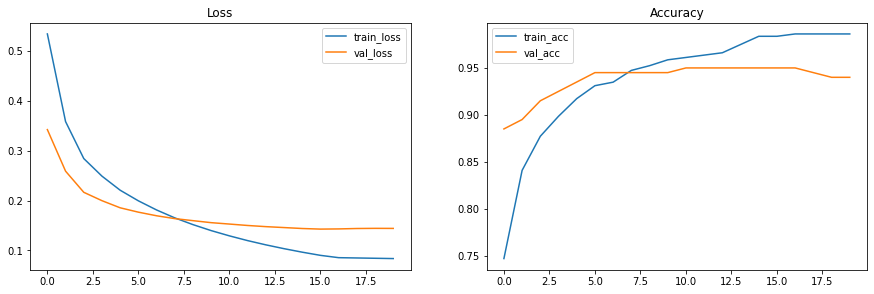

In [40]:
# Plot accuracy
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title('Loss')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()

plt.subplot(222)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

# Evaluation

In [41]:
y_pred = cnn.predict(test_dataset).argmax(axis=1)

In [42]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       100
           1       0.98      0.90      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



<AxesSubplot:>

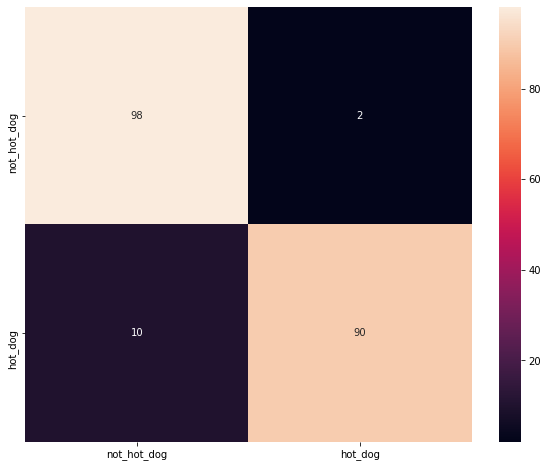

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix(test_labels, y_pred), fmt='', annot=True, 
    xticklabels=list(labels.keys()), yticklabels=list(labels.keys())
)

In [44]:
print('Roc: {}\nMCC: {}'.format(
    round(roc_auc_score(test_labels, y_pred, average='macro'), 2), 
    round(matthews_corrcoef(test_labels, y_pred), 2))
)

Roc: 0.94
MCC: 0.88


# Save model

In [45]:
# Save for the functional api
cnn.save('weights/mobilnet_hd_func.h5')

In [21]:
# If your using submodel api
tf.saved_model.save(cnn, 'weights/mobilenet_hd')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: weights/mobilenet_hd/assets
